<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/280a_custom_object_segmentation_using_stardist_TRAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/3yk9sBja7YI

Training custom models for segmentation using StarDist 

# Imports

In [1]:
# !pip install stardist

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
# matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt

from pathlib import Path

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

2024-06-01 20:13:12.299848: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-01 20:13:12.336424: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 20:13:12.336487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 20:13:12.336525: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-01 20:13:12.345814: I tensorflow/core/platform/cpu_feature_g

# Load data

In [3]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [4]:
#Read input image and corresponding mask names
base_dir = Path("data_2d_split")
X = sorted(list((base_dir / "images_simulated_nuclei" / "train").glob('*.tif')))
Y = sorted(list((base_dir / "labels_simulated_nuclei" / "train").glob('*.tif')))

X_test = sorted(list((base_dir / "images_simulated_nuclei" / "test").glob('*.tif')))
Y_test = sorted(list((base_dir / "labels_simulated_nuclei" / "test").glob('*.tif')))


In [5]:
#Read images and masks using their names.
#We are using tifffile library to read images as we have tif images. 
X = list(map(imread,X))
Y = list(map(imread,Y))

X_test = list(map(imread,X_test))
Y_test = list(map(imread,Y_test))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]  #If no third dim. then number of channels = 1. Otherwise get the num channels from the last dim.

In [6]:
#Normalize input images and fill holes in masks
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]


X_test = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X_test)]
Y_test = [fill_label_holes(y) for y in tqdm(Y_test)]

100%|██████████| 55/55 [00:00<00:00, 246.88it/s]


In [7]:
#Split to train and val
#You can use any method to split. I am following the method used in StarDist documentation example
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.25 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 160
- training:       120
- validation:      40


# Visualize data

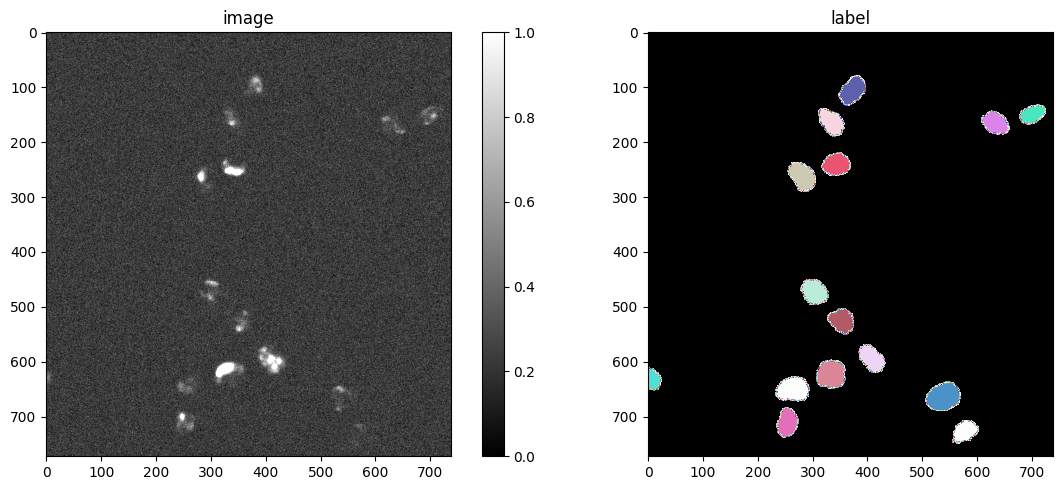

In [8]:
#PLot image and label for some images - sanity check
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()
    
    
i = min(9, len(X)-1)

img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)


In [9]:
#Check config to get an idea about all parameters
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class prediction (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

# Configure model

In [10]:
#Define the config by setting some parameter values

# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [11]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

In [12]:
#Save model to the specified directory
model = StarDist2D(conf, name='stardist_tutorial', basedir='models')

base_model.py (198): output path for model already exists, files may be overwritten: /home/asebaq/dev/cell_segmentation/models/stardist_tutorial
2024-06-01 20:13:19.534382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-01 20:13:19.538766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-01 20:13:19.538921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there mu

Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.493939, nms_thresh=0.3.


In [13]:
#Define the network field of view to size larger than the median object size
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")
    

2024-06-01 20:13:20.297040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-06-01 20:13:20.369915: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


median object size:      [49.  48.5]
network field of view :  [93 93]


2024-06-01 20:13:20.653682: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [14]:
#Define a few augmentation methods
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

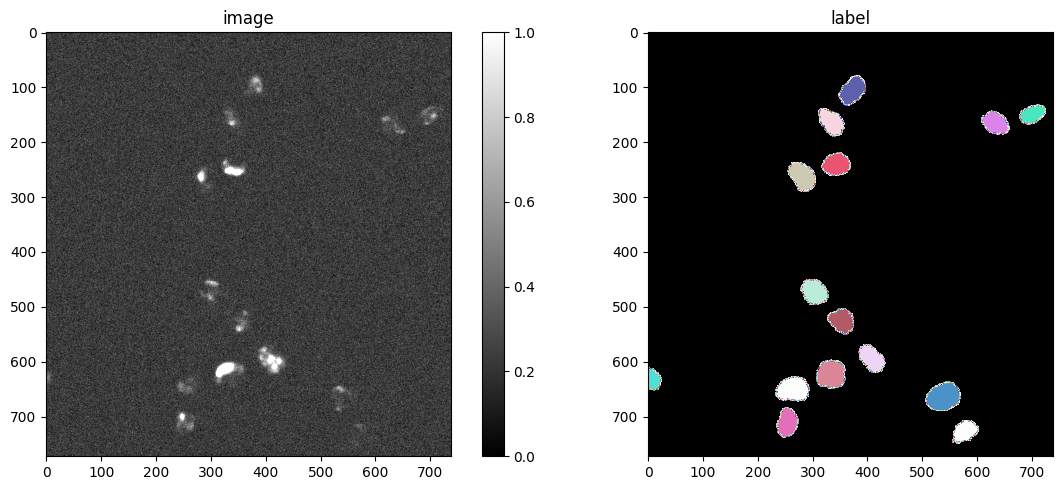

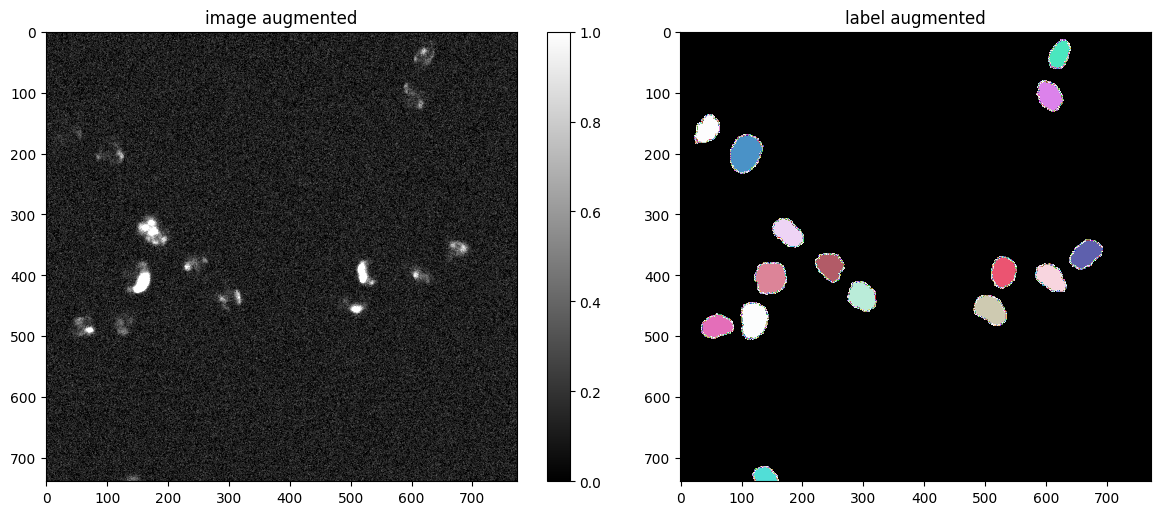

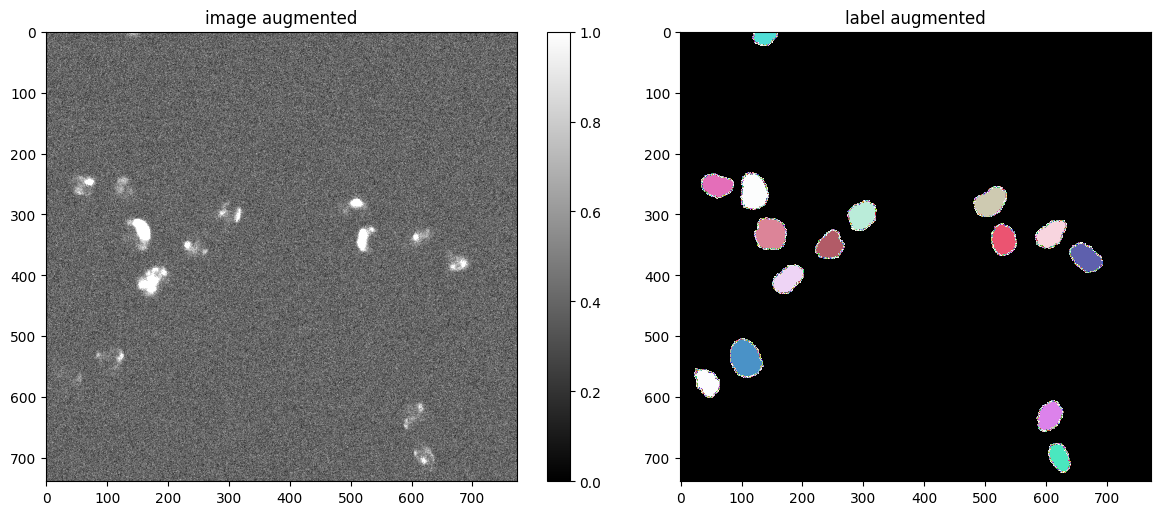

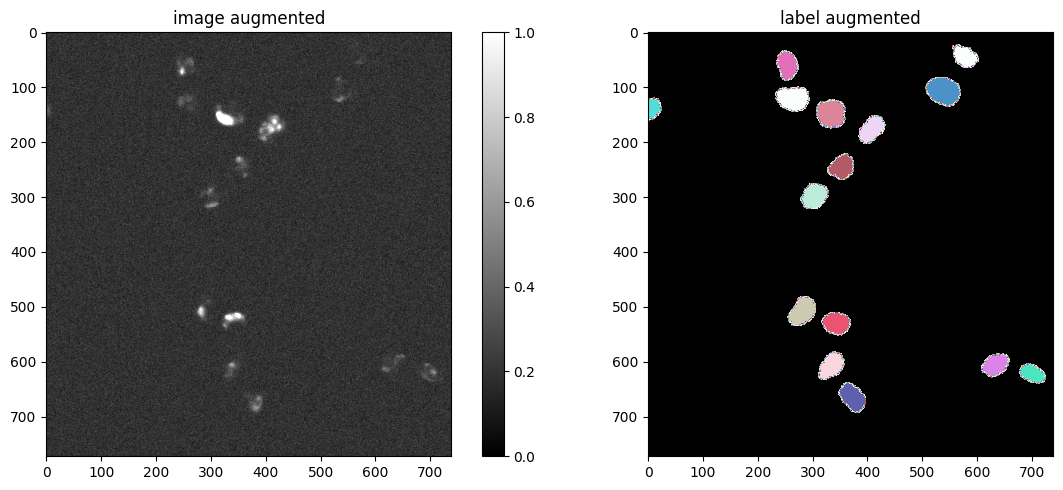

In [15]:
# plot some augmented examples
img, lbl = X[9],Y[9]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")
    

# Training

In [16]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=200, steps_per_epoch=100)

Epoch 1/200


2024-06-01 20:13:26.884691: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7dd31af0e010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-01 20:13:26.884731: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-01 20:13:26.888693: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-01 20:13:26.948243: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 12s 42ms/step - loss: 3.1261 - prob_loss: 0.4220 - dist_loss: 13.5205 - prob_kld: 0.3692 - dist_relevant_mae: 13.5195 - dist_relevant_mse: 301.3132 - dist_dist_iou_metric: 0.2067 - val_loss: 2.2487 - val_prob_loss: 0.2023 - val_dist_loss: 10.2321 - val_prob_kld: 0.1465 - val_dist_relevant_mae: 10.2309 - val_dist_relevant_mse: 179.4529 - val_dist_dist_iou_metric: 0.2568 - lr: 3.0000e-04
Epoch 2/200
100/100 [==============================] - 3s 30ms/step - loss: 1.9788 - prob_loss: 0.1898 - dist_loss: 8.9451 - prob_kld: 0.1359 - dist_relevant_mae: 8.9433 - dist_relevant_mse: 131.8847 - dist_dist_iou_metric: 0.3988 - val_loss: 1.9294 - val_prob_loss: 0.1728 - val_dist_loss: 8.7831 - val_prob_kld: 0.1170 - val_dist_relevant_mae: 8.7816 - val_dist_relevant_mse: 132.7949 - val_dist_dist_iou_metric: 0.3600 - lr: 3.0000e-04
Epoch 3/200
100/100 [==============================] - 3s 30ms/step - loss: 1.8836 - prob_loss: 0.1830 - dist_loss: 8.5026 - prob

In [17]:
#Optimize the thresolds using the trained model
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:25<00:08,  1.70s/it, 0.595 -> 0.853]


Using optimized values: prob_thresh=0.592497, nms_thresh=0.4.
Saving to 'thresholds.json'.


{'prob': 0.5924966167380961, 'nms': 0.4}

In [18]:
#Load saved model
my_model = StarDist2D(None, name='stardist_tutorial', basedir='models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.592497, nms_thresh=0.4.


In [19]:
model=my_model

# Evaluation

In [20]:
#Predict on validation images
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]



100%|██████████| 40/40 [00:08<00:00,  4.49it/s]


100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


DatasetMatching(criterion='iou', thresh=0.5, fp=42, tp=973, fn=68, precision=0.9586206896551724, recall=0.9346781940441883, accuracy=0.8984302862419206, f1=0.9464980544747081, n_true=1041, n_pred=1015, mean_true_score=0.7682278034895458, mean_matched_score=0.8219168997251975, panoptic_quality=0.7779427465297832, by_image=False)

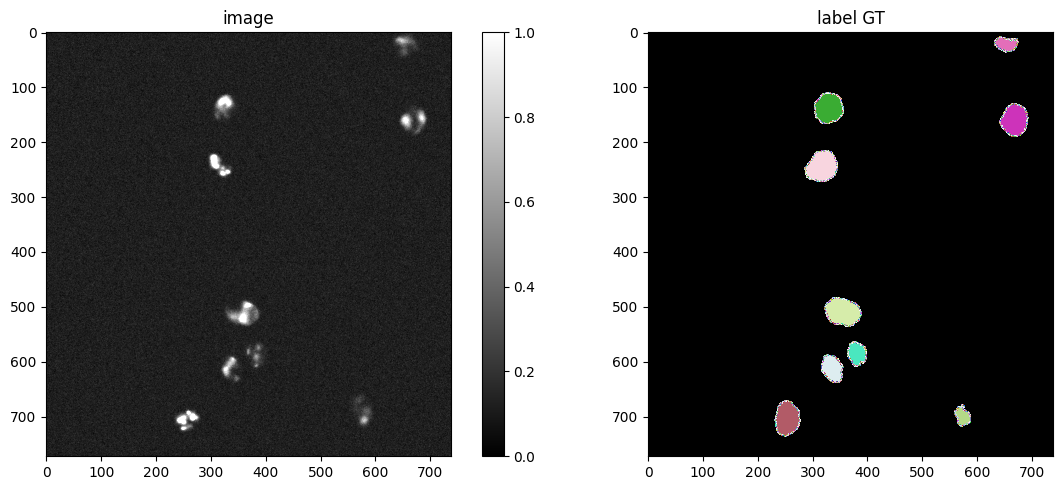

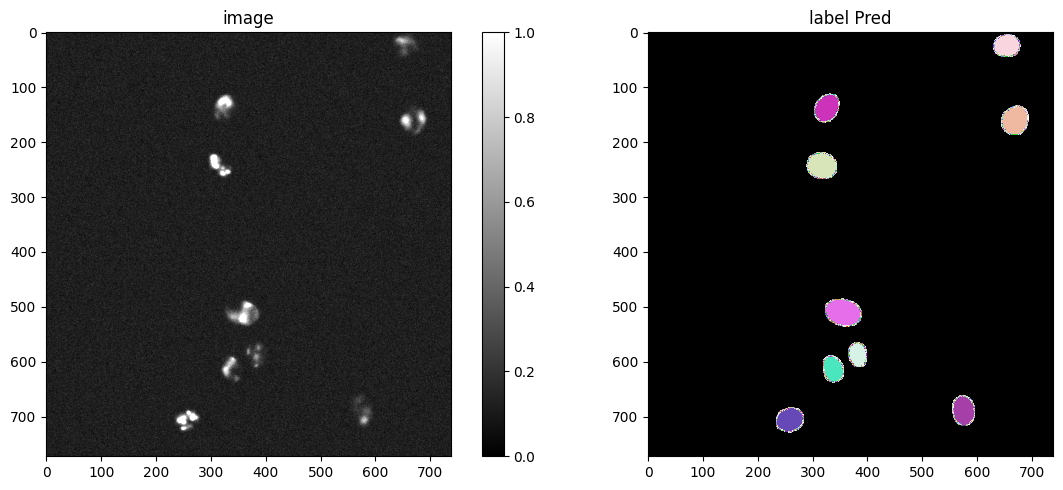

In [21]:
#PLot original labels and predcitions
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.5)]

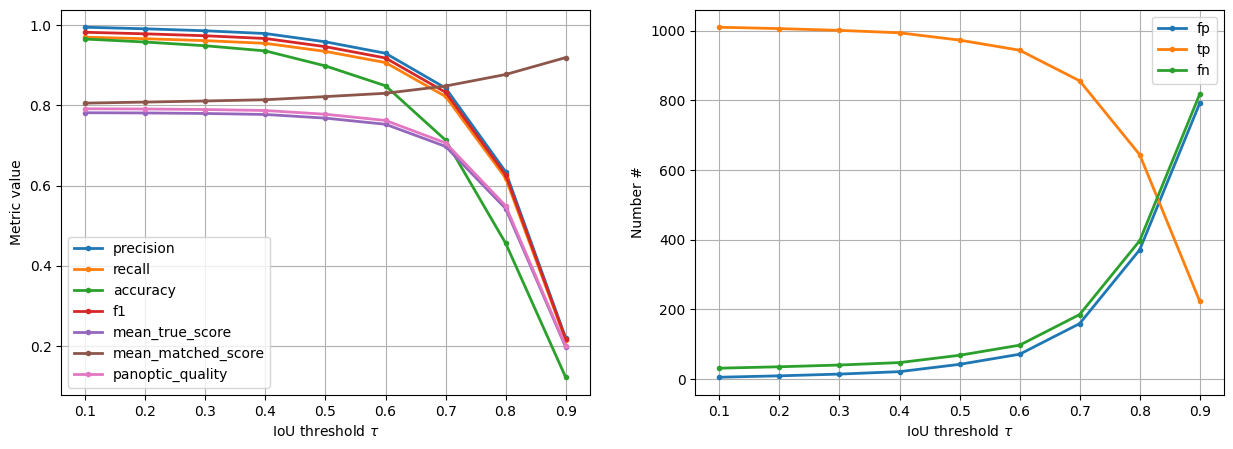

In [22]:
#Plot key metrics 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();



# Test

In [23]:

Y_test_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_test)]

100%|██████████| 55/55 [00:17<00:00,  3.14it/s]


100%|██████████| 9/9 [00:14<00:00,  1.63s/it]


DatasetMatching(criterion='iou', thresh=0.5, fp=28, tp=1561, fn=98, precision=0.9823788546255506, recall=0.9409282700421941, accuracy=0.9253112033195021, f1=0.9612068965517241, n_true=1659, n_pred=1589, mean_true_score=0.796091899446438, mean_matched_score=0.8460707630888152, panoptic_quality=0.8132490524517492, by_image=False)

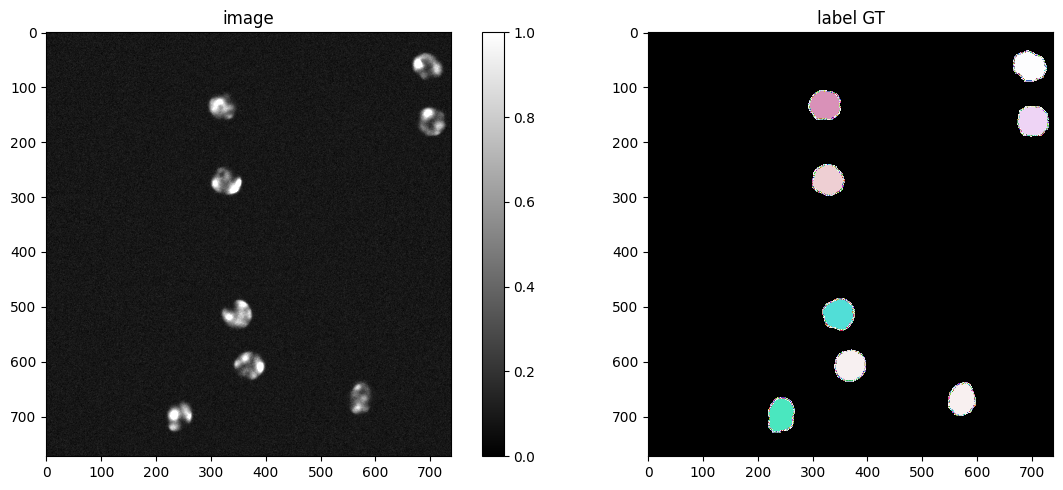

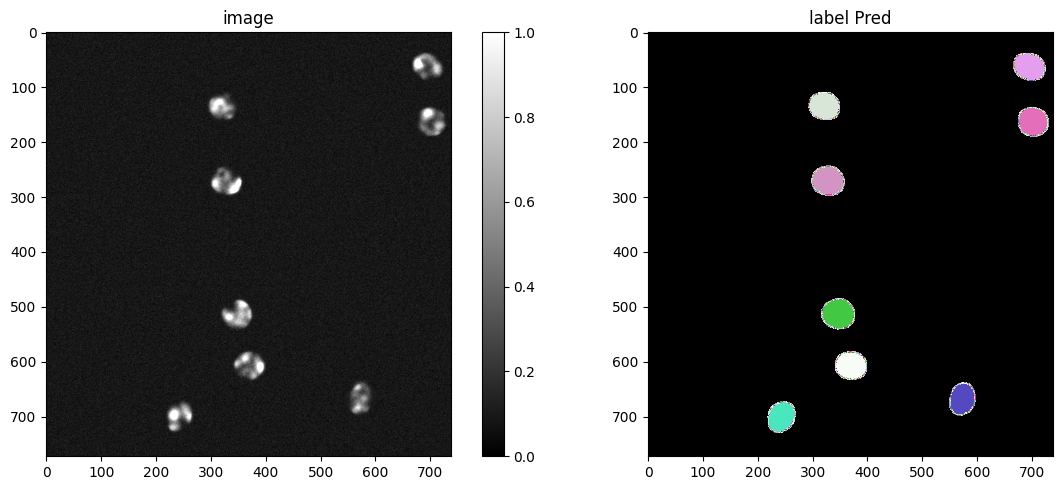

In [24]:
#PLot original labels and predcitions
plot_img_label(X_test[0],Y_test[0], lbl_title="label GT")
plot_img_label(X_test[0],Y_test_pred[0], lbl_title="label Pred")

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_test, Y_test_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.5)]

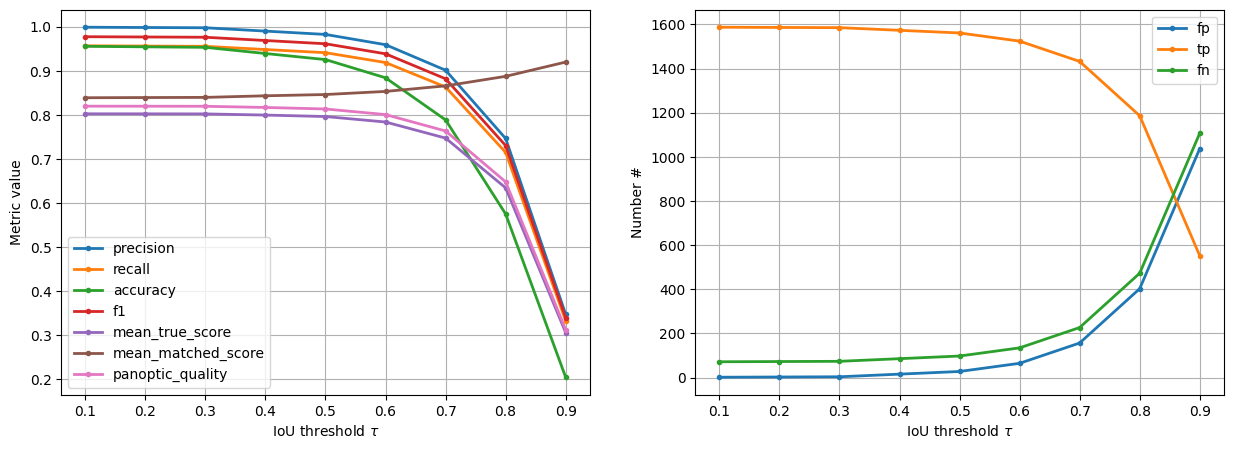

In [25]:
#Plot key metrics 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

